# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: Evaluation

See: [https://riverml.xyz/0.15.0/examples/batch-to-online/](https://riverml.xyz/0.15.0/examples/batch-to-online/)

In [ ]:
pip list | grep spot

In [ ]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotRiver

## 1 The Data

In [ ]:
from sklearn import datasets

# Load the data
dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target

In [ ]:
from pyspotstream.datasets import fetch_opm
ds = fetch_opm(include_categorical=False, data_home="data", return_X_y=True)

## 2.1 Batch Machine Learning with Sklearn

In [ ]:

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing


# Define the steps of the model
sk_model = pipeline.Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LogisticRegression(solver='lbfgs'))
])

# Define a deterministic cross-validation procedure
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

# Compute the MSE values
scorer = metrics.make_scorer(metrics.roc_auc_score)
scores = model_selection.cross_val_score(sk_model, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.3f} (± {scores.std():.3f})')

## 2.2 Batch Machine Learning with River's `compat` Wrapper

* We can train a river model, e.g., LogisticRegression, in an OML manner:
  * the model is trained on single instances and not on the whole data set.

In [ ]:
from river import linear_model
from river import compat
from river import compose
from river import preprocessing

# We define a Pipeline, exactly like we did earlier for sklearn 
rv_model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('log_reg', linear_model.LogisticRegression())
)

# We make the Pipeline compatible with sklearn
# learn_one is called for each observation
rv2sk_model = compat.convert_river_to_sklearn(rv_model)



* Now we can apply sklearn's methods to the wrapped river model
* We compute the CV scores using the same CV scheme and the same scoring
 1. If sklearn's fit is called, then:
   Fit with one pass of the dataset portion is called
   learn_one is called for each observation
 2. If sklearn's predict s called, then:
   A prediction is made for each observation, the same (fitted) model is used,
   i.e., the model is not updated

In [ ]:

scores = model_selection.cross_val_score(rv2sk_model, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.3f} (± {scores.std():.3f})')

## 3.1 Mini Batch for River Models

In [ ]:
from river import linear_model
from river import compose
from river import preprocessing
from river import stream
import pandas as pd


rv_model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.Perceptron())
)

names = ["Assessed Value", "Sale Amount", "Sales Ratio"]

for x in pd.read_csv("data/opm_2001-2020.csv", usecols=names, chunksize=int(985862/10), nrows=985862, header=0):
    y = x.pop("Assessed Value")
    y_pred = rv_model.predict_proba_many(x)
    rv_model.learn_many(x, y)



# Plot Performance for HTs

* See [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/)

In [ ]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree

In [ ]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__

    # To make the generated data reusable
    dataset = list(dataset)
    fig, ax = plt.subplots(figsize=(10, 5), nrows=3, dpi=300)
    for model_name, model in models.items():
        step = []
        error = []
        r_time = []
        memory = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=True, measure_memory=True, step=100
        ):
            step.append(checkpoint["Step"])
            error.append(checkpoint[metric_name].get())

            # Convert timedelta object into seconds
            r_time.append(checkpoint["Time"].total_seconds())
            # Make sure the memory measurements are in MB
            raw_memory = checkpoint["Memory"]
            memory.append(raw_memory * 2**-20)

        ax[0].plot(step, error, label=model_name)
        ax[1].plot(step, r_time, label=model_name)
        ax[2].plot(step, memory, label=model_name)

    ax[0].set_ylabel(metric_name)
    ax[1].set_ylabel('Time (seconds)')
    ax[2].set_ylabel('Memory (MB)')
    ax[2].set_xlabel('Instances')

    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)

    ax[0].legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.25),
        ncol=3, fancybox=True, shadow=True
    )
    plt.tight_layout()
    plt.close()

    return fig

In [ ]:
plot_performance(
    dataset = synth.Friedman(seed=42).take(10_000),
    metric = metrics.MAE(),
    models =
    {
        "Unbounded HTR": (
            preprocessing.StandardScaler() |
            tree.HoeffdingTreeRegressor(splitter=tree.splitter.EBSTSplitter())
        )
    }
)

# Eval_OML from spotRiver

## The OPM Data

In [ ]:
import pandas as pd
from spotRiver.data.opm import fetch_opm
df = fetch_opm(include_categorical=True, data_home="data", return_df=True)
df.shape

In [ ]:
df.isnull().sum()

In [ ]:
for i in ["Location", "lon", "lat"]:
    df.dropna(subset=[i], inplace=True)
df.reset_index(inplace=True)
df.shape

In [ ]:
df.isnull().sum()

In [ ]:
categorical_columns = [
            "Town",
            "Address",
            "Property Type",
            "Residential Type",
            "Non Use Code",
            "Assessor Remarks",
            "OPM remarks",
        ]

In [ ]:
df = df.drop(columns=categorical_columns, axis=1)
df = df.drop(columns=["Location"], axis = 1)
df = df.drop(columns=["Date Recorded"], axis = 1)
df.shape

In [ ]:
df.columns

In [ ]:
df.to_csv("opm.csv", index=False)

In [ ]:
from spotRiver.data.generic import GenericData
opm_dataset = GenericData(filename="opm.csv",
                      directory=".",
                      target="Sale Amount",
                      n_features=7,
                      n_samples=195_832,
                      converters={'index': int,
                                  'Serial Number': int,
                                  'List Year': int,
                                  'Assessed Value': float,
                                  'Sale Amount': float,
                                  'Sales Ratio': float,
                                  'lon': float,
                                  'lat': float,
                                  'timestamp_rec': float},
                      parse_dates=None
                      # parse_dates={"Date Recorded": "%Y-%m-%d"}
                      )

In [ ]:
for x,y in opm_dataset:
    print(x,y)
    break

## Imputation with KNN

In [ ]:
""" import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import KNNImputer
hash_list = list(["Town", "Address", "Property Type",
       "Residential Type", "Non Use Code", "Assessor Remarks", "OPM remarks"])
for i in hash_list:
    df[i + "hash"] = pd.DataFrame(map(lambda x: str(hash(x)), df[i]))
df_num = df.drop(columns=hash_list)
df_num = df_num.drop(columns=["timestamp_rec", "Date Recorded", "Location"])

imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_imp = imputer.fit_transform(df_num) """

In [ ]:
""" from river import stream
params = {
     'converters': {'rating': float},
     'parse_dates': {'year': '%Y'}
}

dataset = stream.iter_csv('tv_shows.csv', target='rating', **params)
for x, y in dataset:
    print(x, y) """

## The GW Data

In [ ]:
from spotRiver.data.generic import GenericData
dataset = GenericData(filename="UnivariateData.csv",
                      directory="/Users/bartz/data/",
                      target="Consumption",
                      n_features=1,
                      n_samples=51_706,
                      converters={"Consumption": float},
                      parse_dates={"Time": "%Y-%m-%d %H:%M:%S%z"})


In [ ]:
for x,y in dataset:
    print(x,y)
    break

In [ ]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive

* TODO: Change dataset

In [ ]:
dataset = opm_dataset  # synth.Friedman(seed=42).take(10_000)

In [ ]:
res_1 = eval_oml_iter_progressive(
    dataset = dataset,
    step = 10000,
    verbose = True,
    metric = metrics.MAE(),
    models =
    {
        "HTR + E-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.EBSTSplitter()
            )
        ),
        "HTR + TE-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.TEBSTSplitter()
            )
        ),
        "HTR + QO": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),

    }
)

In [ ]:
plot_oml_iter_progressive(res_1)

# OPM as in spotRiver

In [1]:
from spotRiver.preprocess.impute import impute_opm
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive, plot_oml_iter_progressive
from river import metrics, tree
from river import preprocessing 

df_0 = impute_opm(write_csv=True, return_df=False, include_categorical=False, path_or_buf="opm_num2.zip")


In [2]:
from spotRiver.data.generic import GenericData
fraction = 0.1
dataset = GenericData(filename="opm_num2.zip",
                      directory=".",
                      target="Sale Amount",
                      n_features=7,
                      n_samples=985_862,
                      fraction = fraction,
                      converters={'List Year': int,
                                  'Assessed Value': float,
                                  'Sale Amount': float,
                                  'Sales Ratio': float,
                                  'lon': float,
                                  'lat': float,
                                  'timestamp_rec': float},
                      parse_dates=None
                      # parse_dates={"Date Recorded": "%Y-%m-%d"}
                      )
n_samples = int(dataset.n_samples * fraction)
for x,y in dataset:
    print(x,y)
    break

{'List Year': 2001, 'Assessed Value': 107530.0, 'Sales Ratio': 0.575026738, 'lat': 41.97461, 'lon': -72.36336, 'timestamp_rec': 1001894400.0} 187000.0


In [3]:
res_num = eval_oml_iter_progressive(
    dataset = list(dataset),
    step = 1_000,
    metric = metrics.MAE(),
    models =
    {
        "HTR + TE-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.TEBSTSplitter()
            )
        ),
        "HTR + QO": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),

    }
)

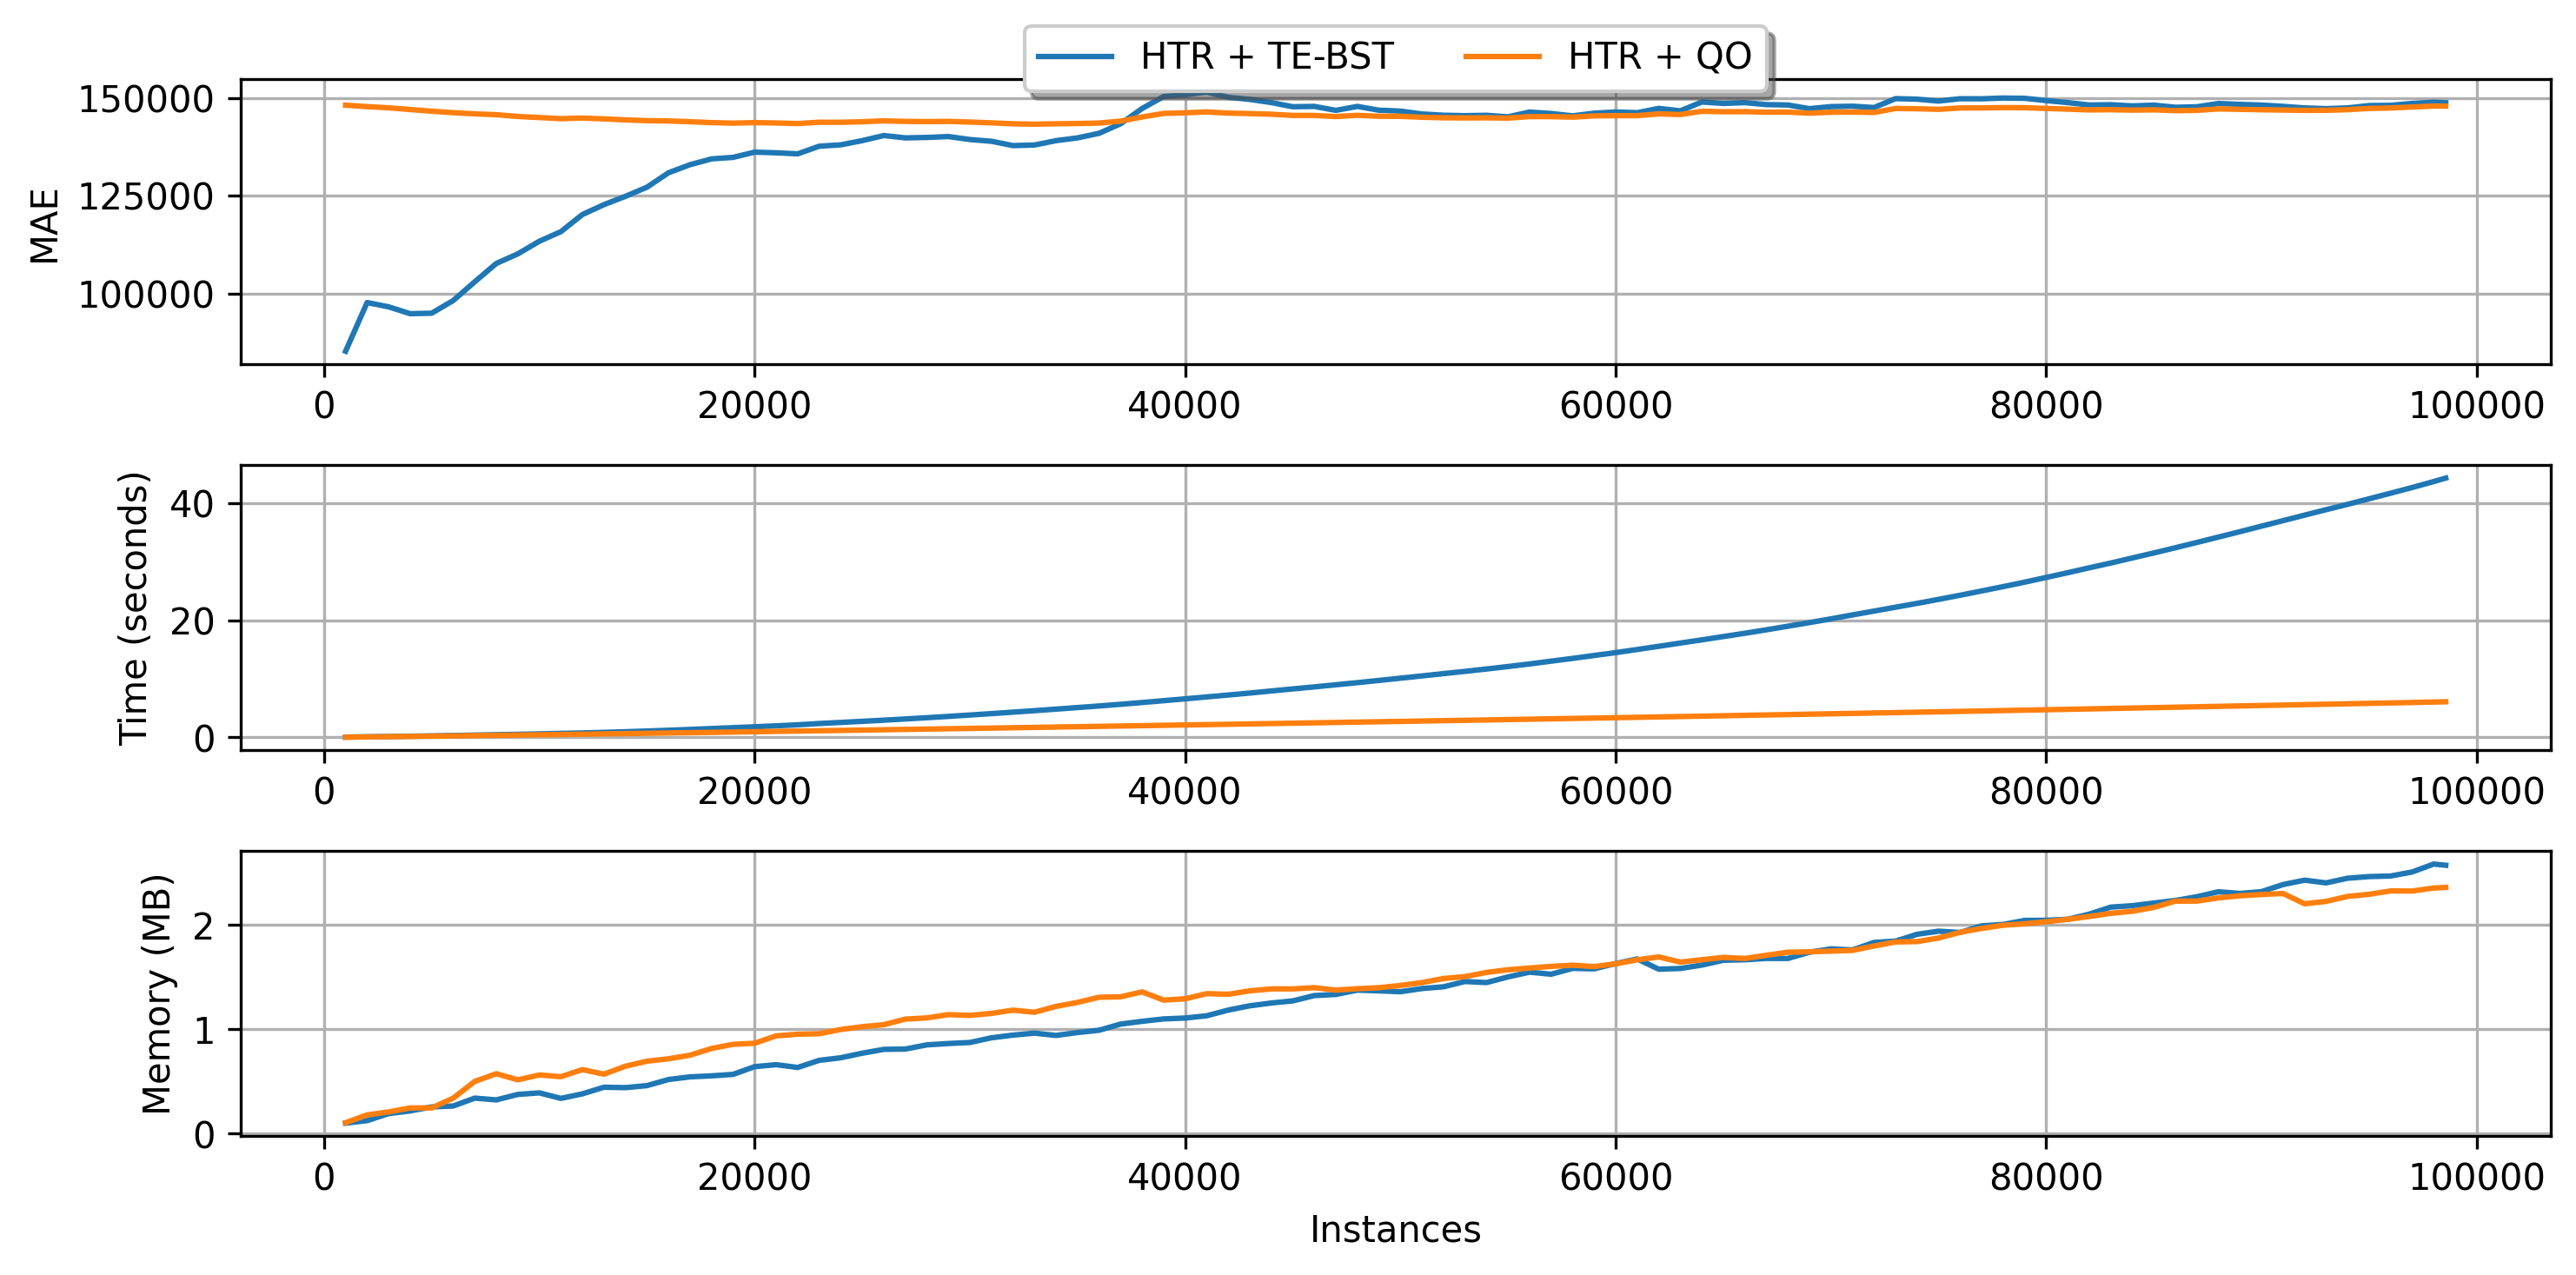

In [4]:
plot_oml_iter_progressive(res_num)

# OPM 2nd Version

In [ ]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive
import pandas as pd
import numpy as np
from spotRiver.data.opm import fetch_opm
X, y = fetch_opm(include_categorical=True, data_home="data", return_X_y=True)
X.shape


In [ ]:
df = pd.concat([X, y], axis=1)
df.isnull().sum()


## Impute Mean for lat ans lon

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df.lat = SimpleImputer().fit_transform(np.array(df.lat).reshape(-1,1))
df.lon = SimpleImputer().fit_transform(np.array(df.lon).reshape(-1,1))
# df = pd.DataFrame(SimpleImputer().fit_transform(df), columns = df.columns)

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

In [ ]:
# df.to_csv("opm_cat.csv", index=False)

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='opm_cat.csv')
df.to_csv('opm_cat.zip', index=False,
          compression=compression_opts)

List Year,Assessed Value,Sale Amount,Sales Ratio,lat,lon,timestamp_rec,Sale Amount

List Year,Assessed Value,Sale Amount,Sales Ratio,lat,lon,timestamp_rec,Town,Address,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Sale Amount

categorical:
Town,Address,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks

In [ ]:
from spotRiver.data.generic import GenericData
opm_cat_dataset = GenericData(filename="opm_cat.csv",
                      directory=".",
                      target="Sale Amount",
                      n_features=7,
                      n_samples=195_832,
                      converters={'List Year': int,
                                  'Assessed Value': float,
                                  'Sale Amount': float,
                                  'Sales Ratio': float,
                                  'lon': float,
                                  'lat': float,
                                  'timestamp_rec': float},
                      parse_dates=None
                      # parse_dates={"Date Recorded": "%Y-%m-%d"}
                      )

In [ ]:
for x,y in opm_cat_dataset:
    print(x,y)
    break

In [ ]:
dataset = opm_cat_dataset 

In [ ]:
import numbers
from river import compose
from river import linear_model
from river import preprocessing

num = compose.SelectType(numbers.Number) | preprocessing.StandardScaler()
#cat = compose.SelectType(str) | preprocessing.OneHotEncoder()
cat = compose.SelectType(str) | preprocessing.FeatureHasher(n_features=100, seed=1)
lin_model = (num + cat) | linear_model.LinearRegression

res_cat = eval_oml_iter_progressive(
    dataset = dataset,
    step = 10000,
    verbose = True,
    metric = metrics.MAE(),
    models =
    {
        "HTR + QO": (
             (num + cat) | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),
    }
)


In [ ]:
plot_oml_iter_progressive(res_cat)

## Numerical (w/o cat)

In [ ]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive
import pandas as pd
import numpy as np
from spotRiver.data.opm import fetch_opm
X, y = fetch_opm(include_categorical=False, data_home="data", return_X_y=True)
X.shape


In [ ]:
df = pd.concat([X, y], axis=1)
df.isnull().sum()

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df.lat = SimpleImputer().fit_transform(np.array(df.lat).reshape(-1,1))
df.lon = SimpleImputer().fit_transform(np.array(df.lon).reshape(-1,1))
# df = pd.DataFrame(SimpleImputer().fit_transform(df), columns = df.columns)

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

In [ ]:
# df.to_csv("opm_num.csv", index=False)

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='opm_num.csv')
df.to_csv('opm_num.zip', index=False,
          compression=compression_opts)

In [ ]:
from spotRiver.data.generic import GenericData
fraction = 1.0
dataset = GenericData(filename="opm_num.zip",
                      directory=".",
                      target="Sale Amount",
                      n_features=7,
                      n_samples=985_862,
                      fraction = fraction,
                      converters={'List Year': int,
                                  'Assessed Value': float,
                                  'Sale Amount': float,
                                  'Sales Ratio': float,
                                  'lon': float,
                                  'lat': float,
                                  'timestamp_rec': float},
                      parse_dates=None
                      # parse_dates={"Date Recorded": "%Y-%m-%d"}
                      )
n_samples = int(dataset.n_samples * fraction)

In [ ]:
for x,y in dataset:
    print(x,y)
    break

In [ ]:
res_num = eval_oml_iter_progressive(
    dataset = dataset,
    step = 10000,
    verbose = True,
    metric = metrics.MAE(),
    models =
    {
        "HTR + TE-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.TEBSTSplitter()
            )
        ),
        "HTR + QO": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),

    }
)

In [ ]:
plot_oml_iter_progressive(res_num)